In [1]:
# https://www.kaggle.com/kratisaxena/stock-market-technical-indicators-visualization
# https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/notebooks
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import math
from collections import OrderedDict

---

In [2]:
# https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
stock_files = []
for filename in os.listdir("./Stocks/"):
    if (filename.endswith(".txt")):
        if(os.path.getsize("./Stocks/"+filename) > 0):
            stock_files.append(filename)
            
# choose a random subset of stocks
# random.seed(14)
# sequence = [i for i in range(len(stock_files))] 
# total_stocks = 1000
# selected_stocks = [stock_files[i] for i in random.sample(sequence, total_stocks)] 
selected_stocks = stock_files

In [3]:
%%time
# Dataset read and preprocessing
# https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
stock_data = []
for stock in selected_stocks:
    df = pd.read_csv("./Stocks/"+stock, usecols=["Date", "Open", "High", "Low", "Close", "Volume"])
    st = stock.split(".us.txt")[0]
    df["Stock"] = st.upper()
    stock_data.append(df)
# concatenate all in one dataframe
stock_data = pd.concat(stock_data, ignore_index=True)

# convert Date to appropriate pandas format, and then sort by Date
stock_data["Date"] = pd.to_datetime(stock_data.Date)
stock_data = stock_data.sort_values(by="Date")

# get rid of stock prices that are zero in any of these columns (Open, High, Low, Close)
# https://stackoverflow.com/questions/49841989/python-drop-value-0-row-in-specific-columns
print("Previously :",stock_data.shape)
stock_data = stock_data.loc[stock_data["Open"] * stock_data["High"] * stock_data["Low"] * stock_data["Close"] != 0]
print("Now        :",stock_data.shape)

# reset once again to fix index of each stock
stock_data.reset_index(inplace=True, drop=True)

Previously : (14887665, 7)
Now        : (14887638, 7)
CPU times: user 31.1 s, sys: 2.9 s, total: 34 s
Wall time: 34 s


---

In [4]:
dates = stock_data.Date.unique()
start_date = pd.to_datetime(min(dates),format='%Y-%m-%d')
end_date   = pd.to_datetime(max(dates),format='%Y-%m-%d')

# find the maximum window size that will allow us to make 1000 transactions totally
# we have 2 transactions per window, 1 buy-low + 1 sell-high
# therefore, divide the total number of days in the range of dates of our dataset by 500
wind_days = math.floor(((end_date-start_date).days)/(1000/2))
window = pd.Timedelta(days=wind_days)

In [5]:
%%time
curr_day = start_date
cnt = 0       # id of time window
cnt2 = 1      # id of move
balance = 1   # starting with 1 dollar
commission = 0.01

win1 = pd.Timedelta(days=1)
# two dictionaries that will save the balance and the portfolio of each day
# Balance is our bank account
# Portfolio is the total value of stocks in our possession
Balance_dict = {}
Portfolio_dict = {}

out_list = [] # log of moves, to save .txt file later
out_file = open("small_log.txt","w")

while curr_day <= (end_date - window) :
    filtered = (stock_data["Date"] >= curr_day) & (stock_data["Date"] <= (curr_day+window))
    stocks_win = stock_data.loc[filtered]
    stock_names_window = stocks_win.Stock.unique()
    
    min_ind, max_ind, max_change, max_profit = -1, -1, 0, -1
    chosen_one = ""

    for stock in stock_names_window:
        curr_stock_df = stocks_win[stocks_win["Stock"]==stock]
        # got to have at least two days of action, because cannot buy-low sell-high on same day!
        if(len(curr_stock_df.index)<2):
            continue
        
        # l_ means local. (1+-0.01) is for taking commission into consideration
        l_min_price = curr_stock_df.iloc[0]["Low"]*(1+commission)
        l_min_ind = curr_stock_df.index[0]
        l_max_ind = curr_stock_df.index[1]
        l_profit = -1
        
        # https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
        for ind, row in curr_stock_df.iterrows():
            price  = row["Low"]*(1+commission)
            change = row["High"]*(1-commission) - l_min_price
            vol = min(math.floor(balance / (curr_stock_df.loc[l_min_ind]["Low"] * (1 + commission))),
                      math.floor(curr_stock_df.loc[l_min_ind]["Volume"]*0.1),
                      math.floor(curr_stock_df.loc[ind]["Volume"]*0.1))
            profit = vol*change
            if(price < l_min_price):
                l_min_ind, l_min_price = ind, price
            elif(profit > l_profit):
                l_max_ind, l_profit = ind, profit

        # after finishing a stock-company, extra criteria have to be applied!
        # have to make sure there is the greatest profit by buying/selling at specific days (1st cond)
        # have to make sure date of Low is earlier than date of High for successful transaction (2nd cond)
        # have to make sure I can buy this stock (can buy at least one stock of it) (3rd cond)
        if((l_profit > max_profit) & (l_min_ind < l_max_ind) & (l_min_price <= balance)):
            min_ind = l_min_ind
            max_ind = l_max_ind
            max_profit = l_profit
            chosen_one = stock
    
    if(chosen_one != ""):
        chosen_stock = stocks_win[stocks_win["Stock"] == chosen_one]
    
        # after deciding which stock will be bought, have to find the volume at which we will buy
        # either buy as much as our balance allows us on sell(Low) day (accounting for commission)
        # or buy 10% of total volume on buy(Low) day
        # or sell 10% of total volume on sell(High) day
        volume = min(math.floor(balance / (chosen_stock.loc[min_ind]["Low"] * (1 + commission))),
                     math.floor(chosen_stock.loc[min_ind]["Volume"]*0.1),
                     math.floor(chosen_stock.loc[max_ind]["Volume"]*0.1))
        if(volume>0):
            price_low = chosen_stock.loc[min_ind]["Low"]*(1+commission)
            price_high = chosen_stock.loc[max_ind]["High"]*(1-commission)
            profit = volume*(price_high - price_low)
            
            prev_balance = balance
            balance += profit
            
            date_buy = chosen_stock.loc[min_ind]["Date"]
            date_sell = chosen_stock.loc[max_ind]["Date"]
            print(cnt2,'\t',cnt,"\tBuy", chosen_one, "(", volume, ") at", date_buy.date(), \
                               "-> Sell at", date_sell.date(), " Balance : ", balance)
            out_file.write(str(cnt2)+"\t"+str(cnt)+"\tBuy "+ str(chosen_one)+ " ( " + str(volume) + " ) at " + str(date_buy.date()) \
                           + " -> Sell at " + str(date_sell.date()) + "  Balance : " + str(balance) + "\n")
            cnt2+=1
            out_list.append(str(date_buy.date()) + " buy-low " + chosen_one + " " + str(volume) + "\n")
            out_list.append(str(date_sell.date()) + " sell-high " + chosen_one + " " + str(volume) + "\n")
            
            # update Balance and Portfolio dictionaries
            #########################################################################
            #########################################################################
            chosen_stock.reset_index(inplace=True, drop=True) # to not have problem with indices from now on...
            # Before buy day
            # Balance is the newly calculated balance
            # Portfolio is 0 (empty)
            temp_day = curr_day
            while(temp_day < date_buy):
                Balance_dict[str(temp_day.date())], Portfolio_dict[str(temp_day.date())] = prev_balance, 0
                temp_day += win1
                # temp_day += win1 if (temp_day.dayofweek!=5) else 3*win1
                if (temp_day.dayofweek==5): # if day is Saturday(==5), got to fill the gaps of weekend - dummy version
                    Balance_dict[str(temp_day.date())], Portfolio_dict[str(temp_day.date())] = prev_balance, 0
                    temp_day += win1
                    Balance_dict[str(temp_day.date())], Portfolio_dict[str(temp_day.date())] = prev_balance, 0
                    temp_day += win1
            ##########################################################
            # Now it is time for buy-day
            # Balance during buy-day is reduced by the price paid for the stocks that are bought
            # Portfolio is the volume of the stock bought, multiplied by the stock price during "Close"
            temp_balance = prev_balance - volume*price_low
            Balance_dict[str(temp_day.date())] = temp_balance
            temp_price = chosen_stock.iloc[chosen_stock.index[chosen_stock["Date"]==date_buy][0]]["Close"]
            Portfolio_dict[str(temp_day.date())] = volume*temp_price
            
            temp_day += win1
            if (temp_day.dayofweek==5):
                Balance_dict[str(temp_day.date())], Portfolio_dict[str(temp_day.date())] = temp_balance, volume*temp_price
                temp_day += win1 
                Balance_dict[str(temp_day.date())], Portfolio_dict[str(temp_day.date())] = temp_balance, volume*temp_price
                temp_day += win1 
            ##########################################################
            # Balance is the same as in buy day in the days between buy and sell 
            # Portfolio changes from day to day according to the "Close" value of the stock bought 
            while(temp_day < date_sell):
                Balance_dict[str(temp_day.date())] = temp_balance
                idx = chosen_stock.index[chosen_stock["Date"]==temp_day]
                if(idx.size > 0):
                    temp_price = chosen_stock.iloc[idx[0]]["Close"]
                    Portfolio_dict[str(temp_day.date())] = volume*temp_price
                else:
                    Portfolio_dict[str(temp_day.date())] = volume*temp_price # don't know why this happened, anyway
                temp_day += win1
                if (temp_day.dayofweek==5):
                    Balance_dict[str(temp_day.date())], Portfolio_dict[str(temp_day.date())] = temp_balance, volume*temp_price
                    temp_day += win1 
                    Balance_dict[str(temp_day.date())], Portfolio_dict[str(temp_day.date())] = temp_balance, volume*temp_price
                    temp_day += win1 
            ##########################################################
            # After sell day (including sell day)
            # Balance is the newly calculated balance
            # Portfolio is 0 (empty)
            while(temp_day <= curr_day+window):
                Balance_dict[str(temp_day.date())] = balance
                Portfolio_dict[str(temp_day.date())] = 0
                # temp_day += win1 if (temp_day.dayofweek!=5) else 3*win1
                temp_day += win1
                if (temp_day.dayofweek==5):
                    Balance_dict[str(temp_day.date())], Portfolio_dict[str(temp_day.date())] = balance, 0
                    temp_day += win1 
                    Balance_dict[str(temp_day.date())], Portfolio_dict[str(temp_day.date())] = balance, 0
                    temp_day += win1             
            #########################################################################
            #########################################################################
    curr_day += pd.Timedelta(days=wind_days+1)
    cnt+=1

out_file.close()

1 	 0 	Buy GE ( 1 ) at 1962-01-08 -> Sell at 1962-01-31  Balance :  1.044107
2 	 1 	Buy GE ( 1 ) at 1962-02-26 -> Sell at 1962-03-09  Balance :  1.071265
3 	 2 	Buy GE ( 1 ) at 1962-04-30 -> Sell at 1962-05-04  Balance :  1.099894
4 	 3 	Buy GE ( 2 ) at 1962-05-29 -> Sell at 1962-05-31  Balance :  1.1919656
5 	 4 	Buy GE ( 2 ) at 1962-06-25 -> Sell at 1962-07-10  Balance :  1.3649108
6 	 5 	Buy GE ( 2 ) at 1962-07-26 -> Sell at 1962-08-20  Balance :  1.4558488
7 	 6 	Buy GE ( 2 ) at 1962-09-27 -> Sell at 1962-10-05  Balance :  1.5302728
8 	 7 	Buy GE ( 2 ) at 1962-10-23 -> Sell at 1962-11-23  Balance :  1.6998928000000002
9 	 8 	Buy GE ( 2 ) at 1962-11-26 -> Sell at 1962-12-12  Balance :  1.7387648000000002
10 	 9 	Buy GE ( 2 ) at 1963-01-07 -> Sell at 1963-01-10  Balance :  1.7608368000000003
11 	 10 	Buy GE ( 2 ) at 1963-03-06 -> Sell at 1963-03-11  Balance :  1.8003688000000004
12 	 11 	Buy GE ( 2 ) at 1963-04-03 -> Sell at 1963-05-08  Balance :  1.9358088000000004
13 	 14 	Buy GE (

94 	 104 	Buy GE ( 271270 ) at 1973-09-12 -> Sell at 1973-10-09  Balance :  307041.6738544
95 	 105 	Buy INTC ( 3040300 ) at 1973-11-07 -> Sell at 1973-11-08  Balance :  350511.8832544
96 	 106 	Buy INTC ( 3898859 ) at 1973-12-11 -> Sell at 1974-01-03  Balance :  501041.76072769996
97 	 107 	Buy AXP ( 308569 ) at 1974-01-09 -> Sell at 1974-01-23  Balance :  588900.9206667
98 	 108 	Buy DIS ( 425446 ) at 1974-02-19 -> Sell at 1974-03-14  Balance :  675548.9548106999
99 	 109 	Buy PG ( 109474 ) at 1974-04-24 -> Sell at 1974-05-08  Balance :  709309.9700927
100 	 110 	Buy IBM ( 64501 ) at 1974-05-30 -> Sell at 1974-06-07  Balance :  769911.8846426998
101 	 111 	Buy INTC ( 6659709 ) at 1974-07-10 -> Sell at 1974-07-24  Balance :  868865.8367900999
102 	 112 	Buy XOM ( 213971 ) at 1974-09-04 -> Sell at 1974-09-06  Balance :  889916.5177410998
103 	 113 	Buy IBM ( 112611 ) at 1974-09-13 -> Sell at 1974-10-18  Balance :  1081629.6507480997
104 	 114 	Buy AXP ( 175671 ) at 1974-10-21 -> Sell a

181 	 191 	Buy TXN ( 4434374 ) at 1983-06-14 -> Sell at 1983-06-16  Balance :  92323352.65112297
182 	 192 	Buy DAL ( 14419 ) at 1983-08-17 -> Sell at 1983-09-01  Balance :  97309245.31082296
183 	 193 	Buy DAL ( 45069 ) at 1983-09-27 -> Sell at 1983-10-05  Balance :  110848829.22182296
184 	 194 	Buy DAL ( 9860 ) at 1983-10-13 -> Sell at 1983-11-21  Balance :  115368274.59782296
185 	 195 	Buy BAX ( 1280510 ) at 1983-12-01 -> Sell at 1983-12-02  Balance :  115998261.18813297
186 	 196 	Buy IBM ( 778908 ) at 1984-02-09 -> Sell at 1984-02-10  Balance :  116296380.43605296
187 	 197 	Buy DAL ( 18961 ) at 1984-02-17 -> Sell at 1984-03-16  Balance :  122197794.49165297
188 	 198 	Buy DAL ( 16028 ) at 1984-04-06 -> Sell at 1984-05-02  Balance :  125386547.46085297
189 	 199 	Buy DAL ( 22597 ) at 1984-05-18 -> Sell at 1984-05-30  Balance :  127675205.51635297
190 	 200 	Buy IBM ( 679748 ) at 1984-06-18 -> Sell at 1984-06-21  Balance :  128653784.33211297
191 	 201 	Buy DAL ( 15179 ) at 1984-

267 	 277 	Buy DAL ( 34964 ) at 1993-02-19 -> Sell at 1993-02-25  Balance :  602612554.7646478
268 	 278 	Buy DAL ( 11855 ) at 1993-03-18 -> Sell at 1993-04-21  Balance :  611929866.3516479
269 	 279 	Buy INTC ( 15436020 ) at 1993-04-28 -> Sell at 1993-06-07  Balance :  622120248.2390279
270 	 280 	Buy ORCL ( 9218148 ) at 1993-06-08 -> Sell at 1993-06-30  Balance :  624386244.1622399
271 	 281 	Buy DAL ( 30268 ) at 1993-07-19 -> Sell at 1993-08-25  Balance :  641785816.0694399
272 	 282 	Buy INTC ( 10821734 ) at 1993-09-08 -> Sell at 1993-09-29  Balance :  648609774.2734259
273 	 283 	Buy DAL ( 12166 ) at 1993-10-11 -> Sell at 1993-11-17  Balance :  655990922.9714259
274 	 284 	Buy INTC ( 9478569 ) at 1993-11-22 -> Sell at 1993-12-28  Balance :  659445984.5933229
275 	 285 	Buy ORCL ( 9014821 ) at 1994-01-03 -> Sell at 1994-01-12  Balance :  662505641.8851858
276 	 286 	Buy INTC ( 7728983 ) at 1994-02-10 -> Sell at 1994-03-17  Balance :  666509193.2473218
277 	 287 	Buy DAL ( 27461 ) a

352 	 362 	Buy C ( 280871 ) at 2002-09-23 -> Sell at 2002-09-30  Balance :  5047750737.422349
353 	 363 	Buy DAL ( 97484 ) at 2002-10-10 -> Sell at 2002-11-06  Balance :  5153025132.288749
354 	 364 	Buy DAL ( 64451 ) at 2002-11-13 -> Sell at 2002-12-02  Balance :  5191477423.861548
355 	 365 	Buy CSCO ( 5639960 ) at 2002-12-31 -> Sell at 2003-01-14  Balance :  5202849388.008748
356 	 366 	Buy DAL ( 117538 ) at 2003-03-12 -> Sell at 2003-03-14  Balance :  5234451312.901548
357 	 367 	Buy DAL ( 146741 ) at 2003-03-17 -> Sell at 2003-04-17  Balance :  5339217093.873848
358 	 368 	Buy DAL ( 79656 ) at 2003-04-25 -> Sell at 2003-05-06  Balance :  5386064500.077848
359 	 369 	Buy INTC ( 7637936 ) at 2003-06-25 -> Sell at 2003-07-15  Balance :  5412622061.826009
360 	 370 	Buy INTC ( 7172451 ) at 2003-08-08 -> Sell at 2003-08-22  Balance :  5442459744.884048
361 	 371 	Buy DAL ( 53720 ) at 2003-08-28 -> Sell at 2003-10-03  Balance :  5469611653.992048
362 	 372 	Buy INTC ( 5979730 ) at 2003-

436 	 446 	Buy AAPL ( 9035928 ) at 2012-01-26 -> Sell at 2012-03-01  Balance :  12495257976.737453
437 	 447 	Buy AAPL ( 18262904 ) at 2012-03-07 -> Sell at 2012-04-10  Balance :  12750210125.496893
438 	 448 	Buy AMZN ( 348125 ) at 2012-04-23 -> Sell at 2012-04-30  Balance :  12765575144.559393
439 	 449 	Buy AAPL ( 13501516 ) at 2012-06-04 -> Sell at 2012-07-05  Balance :  12859341282.967154
440 	 450 	Buy AAPL ( 12289135 ) at 2012-07-25 -> Sell at 2012-08-17  Balance :  12967527576.917503
441 	 451 	Buy AAPL ( 15687715 ) at 2012-08-22 -> Sell at 2012-09-21  Balance :  13055169663.676554
442 	 452 	Buy FB ( 3482767 ) at 2012-10-19 -> Sell at 2012-10-24  Balance :  13072651412.633053
443 	 453 	Buy FB ( 6731471 ) at 2012-11-12 -> Sell at 2012-12-03  Balance :  13136819159.940554
444 	 454 	Buy FB ( 5654319 ) at 2012-12-28 -> Sell at 2013-01-28  Balance :  13175174667.445154
445 	 455 	Buy STZ ( 3925091 ) at 2013-01-31 -> Sell at 2013-02-14  Balance :  13232761208.291645
446 	 456 	Buy

In [6]:
tot_moves = len(out_list)

print("Finally, balance is :", balance, "after", tot_moves, "moves")

out_file = open("small.txt","w")

out_file.write(str(tot_moves)+"\n") # first, write total count of moves
for move in out_list:               # then write every move that occured
    out_file.write(move)

out_file.close()

Finally, balance is : 16909153723.90599 after 972 moves


---

In [7]:
print((end_date-start_date).days)
print(len(Portfolio_dict), len(Balance_dict))
# Some dates are missing, because no transaction was made within some time windows
# Have to fill these gaps 

20401
19928 19928


In [8]:
new_date = start_date
while (new_date<=end_date):
    # what stands for Balance stands also for Portfolio, as they are created together
    if(str(new_date.date()) not in Balance_dict.keys()): 
        Balance_dict[str(new_date.date())] = Balance_dict[str((new_date-win1).date())]
        Portfolio_dict[str(new_date.date())] = Portfolio_dict[str((new_date-win1).date())]
    new_date+=win1

# after filling the gaps, order/sort the two dictionaries, so that dates are aligned correctly
Portfolio_dict = OrderedDict(sorted(Portfolio_dict.items(), key=lambda t: t[0]))
Balance_dict = OrderedDict(sorted(Balance_dict.items(), key=lambda t: t[0]))

In [10]:
out_file = open("small_valuation.txt","w")

print((end_date-start_date).days)
print(len(Portfolio_dict), len(Balance_dict))

for i,j in zip(Portfolio_dict,Balance_dict):
    print(i,":Portfolio:",Portfolio_dict[i],'\tBalance:',Balance_dict[j])
    out_file.write(str(i) + " :Portfolio: " + str(Portfolio_dict[i]) + "\tBalance: " + str(Balance_dict[j]) + "\n")
    
out_file.close()

20401
20402 20402
1962-01-02 :Portfolio: 0 	Balance: 1
1962-01-03 :Portfolio: 0 	Balance: 1
1962-01-04 :Portfolio: 0 	Balance: 1
1962-01-05 :Portfolio: 0 	Balance: 1
1962-01-06 :Portfolio: 0 	Balance: 1
1962-01-07 :Portfolio: 0 	Balance: 1
1962-01-08 :Portfolio: 0.5957 	Balance: 0.42268399999999995
1962-01-09 :Portfolio: 0.5957 	Balance: 0.42268399999999995
1962-01-10 :Portfolio: 0.5957 	Balance: 0.42268399999999995
1962-01-11 :Portfolio: 0.5957 	Balance: 0.42268399999999995
1962-01-12 :Portfolio: 0.5878 	Balance: 0.42268399999999995
1962-01-13 :Portfolio: 0.5878 	Balance: 0.42268399999999995
1962-01-14 :Portfolio: 0.5878 	Balance: 0.42268399999999995
1962-01-15 :Portfolio: 0.5957 	Balance: 0.42268399999999995
1962-01-16 :Portfolio: 0.6037 	Balance: 0.42268399999999995
1962-01-17 :Portfolio: 0.5878 	Balance: 0.42268399999999995
1962-01-18 :Portfolio: 0.5957 	Balance: 0.42268399999999995
1962-01-19 :Portfolio: 0.6037 	Balance: 0.42268399999999995
1962-01-20 :Portfolio: 0.6037 	Balance: 

1965-03-19 :Portfolio: 0 	Balance: 3.3160487999999986
1965-03-20 :Portfolio: 0 	Balance: 3.3160487999999986
1965-03-21 :Portfolio: 0 	Balance: 3.3160487999999986
1965-03-22 :Portfolio: 0 	Balance: 3.3160487999999986
1965-03-23 :Portfolio: 0 	Balance: 3.3160487999999986
1965-03-24 :Portfolio: 0 	Balance: 3.3160487999999986
1965-03-25 :Portfolio: 0 	Balance: 3.3160487999999986
1965-03-26 :Portfolio: 0 	Balance: 3.3160487999999986
1965-03-27 :Portfolio: 0 	Balance: 3.3160487999999986
1965-03-28 :Portfolio: 0 	Balance: 3.3160487999999986
1965-03-29 :Portfolio: 0 	Balance: 3.3160487999999986
1965-03-30 :Portfolio: 0 	Balance: 3.3160487999999986
1965-03-31 :Portfolio: 0 	Balance: 3.3160487999999986
1965-04-01 :Portfolio: 0 	Balance: 3.3160487999999986
1965-04-02 :Portfolio: 0 	Balance: 3.3160487999999986
1965-04-03 :Portfolio: 0 	Balance: 3.3160487999999986
1965-04-04 :Portfolio: 0 	Balance: 3.3160487999999986
1965-04-05 :Portfolio: 2.5119000000000002 	Balance: 0.8032697999999985
1965-04-06 

1968-07-01 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-02 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-03 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-04 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-05 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-06 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-07 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-08 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-09 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-10 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-11 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-12 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-13 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-14 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-15 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-16 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-17 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-18 :Portfolio: 0 	Balance: 19.342402799999995
1968-07-19 :Portfolio: 0 	Ba

1971-10-14 :Portfolio: 0 	Balance: 2959.214560499999
1971-10-15 :Portfolio: 3035.5950000000003 	Balance: 0.2789684999988822
1971-10-16 :Portfolio: 3035.5950000000003 	Balance: 0.2789684999988822
1971-10-17 :Portfolio: 3035.5950000000003 	Balance: 0.2789684999988822
1971-10-18 :Portfolio: 3070.398 	Balance: 0.2789684999988822
1971-10-19 :Portfolio: 3105.9744 	Balance: 0.2789684999988822
1971-10-20 :Portfolio: 3141.5508 	Balance: 0.2789684999988822
1971-10-21 :Portfolio: 3212.3169 	Balance: 0.2789684999988822
1971-10-22 :Portfolio: 3176.3538 	Balance: 0.2789684999988822
1971-10-23 :Portfolio: 3176.3538 	Balance: 0.2789684999988822
1971-10-24 :Portfolio: 3176.3538 	Balance: 0.2789684999988822
1971-10-25 :Portfolio: 3247.5066 	Balance: 0.2789684999988822
1971-10-26 :Portfolio: 3281.9229 	Balance: 0.2789684999988822
1971-10-27 :Portfolio: 3317.886 	Balance: 0.2789684999988822
1971-10-28 :Portfolio: 3317.886 	Balance: 0.2789684999988822
1971-10-29 :Portfolio: 3353.0757 	Balance: 0.2789684999

1975-02-15 :Portfolio: 0 	Balance: 1588865.0972050999
1975-02-16 :Portfolio: 0 	Balance: 1588865.0972050999
1975-02-17 :Portfolio: 0 	Balance: 1588865.0972050999
1975-02-18 :Portfolio: 0 	Balance: 1588865.0972050999
1975-02-19 :Portfolio: 0 	Balance: 1588865.0972050999
1975-02-20 :Portfolio: 0 	Balance: 1588865.0972050999
1975-02-21 :Portfolio: 0 	Balance: 1588865.0972050999
1975-02-22 :Portfolio: 0 	Balance: 1588865.0972050999
1975-02-23 :Portfolio: 0 	Balance: 1588865.0972050999
1975-02-24 :Portfolio: 0 	Balance: 1588865.0972050999
1975-02-25 :Portfolio: 316849.3275 	Balance: 1273786.9705931
1975-02-26 :Portfolio: 326420.54370000004 	Balance: 1273786.9705931
1975-02-27 :Portfolio: 321634.9356 	Balance: 1273786.9705931
1975-02-28 :Portfolio: 331206.1518 	Balance: 1273786.9705931
1975-03-01 :Portfolio: 331206.1518 	Balance: 1273786.9705931
1975-03-02 :Portfolio: 331206.1518 	Balance: 1273786.9705931
1975-03-03 :Portfolio: 355291.9596 	Balance: 1273786.9705931
1975-03-04 :Portfolio: 350

1978-05-28 :Portfolio: 1321312.5 	Balance: 3593570.6103449985
1978-05-29 :Portfolio: 1321312.5 	Balance: 3593570.6103449985
1978-05-30 :Portfolio: 1311187.5 	Balance: 3593570.6103449985
1978-05-31 :Portfolio: 1336500.0 	Balance: 3593570.6103449985
1978-06-01 :Portfolio: 1351687.5 	Balance: 3593570.6103449985
1978-06-02 :Portfolio: 1422562.5 	Balance: 3593570.6103449985
1978-06-03 :Portfolio: 1422562.5 	Balance: 3593570.6103449985
1978-06-04 :Portfolio: 1422562.5 	Balance: 3593570.6103449985
1978-06-05 :Portfolio: 1458000.0 	Balance: 3593570.6103449985
1978-06-06 :Portfolio: 1463062.5 	Balance: 3593570.6103449985
1978-06-07 :Portfolio: 1488375.0 	Balance: 3593570.6103449985
1978-06-08 :Portfolio: 1539000.0 	Balance: 3593570.6103449985
1978-06-09 :Portfolio: 1498500.0 	Balance: 3593570.6103449985
1978-06-10 :Portfolio: 1498500.0 	Balance: 3593570.6103449985
1978-06-11 :Portfolio: 1498500.0 	Balance: 3593570.6103449985
1978-06-12 :Portfolio: 1528875.0 	Balance: 3593570.6103449985
1978-06-

1981-08-22 :Portfolio: 0 	Balance: 30126792.76981099
1981-08-23 :Portfolio: 0 	Balance: 30126792.76981099
1981-08-24 :Portfolio: 0 	Balance: 30126792.76981099
1981-08-25 :Portfolio: 0 	Balance: 30126792.76981099
1981-08-26 :Portfolio: 0 	Balance: 30126792.76981099
1981-08-27 :Portfolio: 0 	Balance: 30126792.76981099
1981-08-28 :Portfolio: 0 	Balance: 30126792.76981099
1981-08-29 :Portfolio: 0 	Balance: 30126792.76981099
1981-08-30 :Portfolio: 0 	Balance: 30126792.76981099
1981-08-31 :Portfolio: 0 	Balance: 30126792.76981099
1981-09-01 :Portfolio: 0 	Balance: 30126792.76981099
1981-09-02 :Portfolio: 0 	Balance: 30126792.76981099
1981-09-03 :Portfolio: 0 	Balance: 30126792.76981099
1981-09-04 :Portfolio: 0 	Balance: 30126792.76981099
1981-09-05 :Portfolio: 0 	Balance: 30126792.76981099
1981-09-06 :Portfolio: 0 	Balance: 30126792.76981099
1981-09-07 :Portfolio: 0 	Balance: 30126792.76981099
1981-09-08 :Portfolio: 0 	Balance: 30126792.76981099
1981-09-09 :Portfolio: 0 	Balance: 30126792.76

1985-01-08 :Portfolio: 0 	Balance: 154109308.520313
1985-01-09 :Portfolio: 0 	Balance: 154109308.520313
1985-01-10 :Portfolio: 0 	Balance: 154109308.520313
1985-01-11 :Portfolio: 0 	Balance: 154109308.520313
1985-01-12 :Portfolio: 0 	Balance: 154109308.520313
1985-01-13 :Portfolio: 0 	Balance: 154109308.520313
1985-01-14 :Portfolio: 0 	Balance: 154109308.520313
1985-01-15 :Portfolio: 0 	Balance: 154109308.520313
1985-01-16 :Portfolio: 0 	Balance: 154109308.520313
1985-01-17 :Portfolio: 0 	Balance: 154109308.520313
1985-01-18 :Portfolio: 96772424.64 	Balance: 57238161.12911299
1985-01-19 :Portfolio: 96772424.64 	Balance: 57238161.12911299
1985-01-20 :Portfolio: 96772424.64 	Balance: 57238161.12911299
1985-01-21 :Portfolio: 98549219.84 	Balance: 57238161.12911299
1985-01-22 :Portfolio: 98835442.88 	Balance: 57238161.12911299
1985-01-23 :Portfolio: 101759895.68 	Balance: 57238161.12911299
1985-01-24 :Portfolio: 103192739.28 	Balance: 57238161.12911299
1985-01-25 :Portfolio: 104053482.48 	

1988-05-16 :Portfolio: 0 	Balance: 311927246.7411989
1988-05-17 :Portfolio: 0 	Balance: 311927246.7411989
1988-05-18 :Portfolio: 0 	Balance: 311927246.7411989
1988-05-19 :Portfolio: 0 	Balance: 311927246.7411989
1988-05-20 :Portfolio: 0 	Balance: 311927246.7411989
1988-05-21 :Portfolio: 0 	Balance: 311927246.7411989
1988-05-22 :Portfolio: 0 	Balance: 311927246.7411989
1988-05-23 :Portfolio: 0 	Balance: 311927246.7411989
1988-05-24 :Portfolio: 32486467.86 	Balance: 279294648.3273989
1988-05-25 :Portfolio: 32840299.8 	Balance: 279294648.3273989
1988-05-26 :Portfolio: 33290860.68 	Balance: 279294648.3273989
1988-05-27 :Portfolio: 32840299.8 	Balance: 279294648.3273989
1988-05-28 :Portfolio: 32840299.8 	Balance: 279294648.3273989
1988-05-29 :Portfolio: 32840299.8 	Balance: 279294648.3273989
1988-05-30 :Portfolio: 32840299.8 	Balance: 279294648.3273989
1988-05-31 :Portfolio: 33821948.16 	Balance: 279294648.3273989
1988-06-01 :Portfolio: 34079342.22 	Balance: 279294648.3273989
1988-06-02 :Po

1991-07-01 :Portfolio: 70976210.7 	Balance: 403989942.6438228
1991-07-02 :Portfolio: 71361703.3 	Balance: 403989942.6438228
1991-07-03 :Portfolio: 72367779.60000001 	Balance: 403989942.6438228
1991-07-04 :Portfolio: 72367779.60000001 	Balance: 403989942.6438228
1991-07-05 :Portfolio: 72367779.60000001 	Balance: 403989942.6438228
1991-07-06 :Portfolio: 72367779.60000001 	Balance: 403989942.6438228
1991-07-07 :Portfolio: 72367779.60000001 	Balance: 403989942.6438228
1991-07-08 :Portfolio: 0 	Balance: 478135394.3868228
1991-07-09 :Portfolio: 0 	Balance: 478135394.3868228
1991-07-10 :Portfolio: 0 	Balance: 478135394.3868228
1991-07-11 :Portfolio: 0 	Balance: 478135394.3868228
1991-07-12 :Portfolio: 0 	Balance: 478135394.3868228
1991-07-13 :Portfolio: 0 	Balance: 478135394.3868228
1991-07-14 :Portfolio: 0 	Balance: 478135394.3868228
1991-07-15 :Portfolio: 0 	Balance: 478135394.3868228
1991-07-16 :Portfolio: 0 	Balance: 478135394.3868228
1991-07-17 :Portfolio: 0 	Balance: 478135394.3868228
1

1994-10-12 :Portfolio: 0 	Balance: 696684152.6937758
1994-10-13 :Portfolio: 0 	Balance: 696684152.6937758
1994-10-14 :Portfolio: 0 	Balance: 696684152.6937758
1994-10-15 :Portfolio: 0 	Balance: 696684152.6937758
1994-10-16 :Portfolio: 0 	Balance: 696684152.6937758
1994-10-17 :Portfolio: 41630076.6882 	Balance: 655096926.4892797
1994-10-18 :Portfolio: 41747671.723799996 	Balance: 655096926.4892797
1994-10-19 :Portfolio: 42896374.4496 	Balance: 655096926.4892797
1994-10-20 :Portfolio: 43472876.9412 	Balance: 655096926.4892797
1994-10-21 :Portfolio: 43356715.991399996 	Balance: 655096926.4892797
1994-10-22 :Portfolio: 43356715.991399996 	Balance: 655096926.4892797
1994-10-23 :Portfolio: 43356715.991399996 	Balance: 655096926.4892797
1994-10-24 :Portfolio: 42549325.686000004 	Balance: 655096926.4892797
1994-10-25 :Portfolio: 42209447.351399995 	Balance: 655096926.4892797
1994-10-26 :Portfolio: 42896374.4496 	Balance: 655096926.4892797
1994-10-27 :Portfolio: 43356715.991399996 	Balance: 655

1998-01-24 :Portfolio: 238254416.021 	Balance: 1182627410.7524815
1998-01-25 :Portfolio: 238254416.021 	Balance: 1182627410.7524815
1998-01-26 :Portfolio: 239707469.619 	Balance: 1182627410.7524815
1998-01-27 :Portfolio: 244453080.838 	Balance: 1182627410.7524815
1998-01-28 :Portfolio: 249616058.516 	Balance: 1182627410.7524815
1998-01-29 :Portfolio: 253125028.375 	Balance: 1182627410.7524815
1998-01-30 :Portfolio: 250017966.958 	Balance: 1182627410.7524815
1998-01-31 :Portfolio: 250017966.958 	Balance: 1182627410.7524815
1998-02-01 :Portfolio: 250017966.958 	Balance: 1182627410.7524815
1998-02-02 :Portfolio: 256355753.928 	Balance: 1182627410.7524815
1998-02-03 :Portfolio: 266403464.97800002 	Balance: 1182627410.7524815
1998-02-04 :Portfolio: 270252511.211 	Balance: 1182627410.7524815
1998-02-05 :Portfolio: 266990869.62400004 	Balance: 1182627410.7524815
1998-02-06 :Portfolio: 270252511.211 	Balance: 1182627410.7524815
1998-02-07 :Portfolio: 270252511.211 	Balance: 1182627410.7524815


2001-05-08 :Portfolio: 208636826.54400003 	Balance: 4104877895.5985107
2001-05-09 :Portfolio: 195837857.376 	Balance: 4104877895.5985107
2001-05-10 :Portfolio: 192765113.568 	Balance: 4104877895.5985107
2001-05-11 :Portfolio: 194995330.848 	Balance: 4104877895.5985107
2001-05-12 :Portfolio: 194995330.848 	Balance: 4104877895.5985107
2001-05-13 :Portfolio: 194995330.848 	Balance: 4104877895.5985107
2001-05-14 :Portfolio: 190088852.83200002 	Balance: 4104877895.5985107
2001-05-15 :Portfolio: 191835856.36799997 	Balance: 4104877895.5985107
2001-05-16 :Portfolio: 204721556.208 	Balance: 4104877895.5985107
2001-05-17 :Portfolio: 203284305.072 	Balance: 4104877895.5985107
2001-05-18 :Portfolio: 206790702.24 	Balance: 4104877895.5985107
2001-05-19 :Portfolio: 206790702.24 	Balance: 4104877895.5985107
2001-05-20 :Portfolio: 206790702.24 	Balance: 4104877895.5985107
2001-05-21 :Portfolio: 234098473.82400003 	Balance: 4104877895.5985107
2001-05-22 :Portfolio: 0 	Balance: 4349429026.110991
2001-0

2004-08-20 :Portfolio: 98965013.2 	Balance: 5672692269.141249
2004-08-21 :Portfolio: 98965013.2 	Balance: 5672692269.141249
2004-08-22 :Portfolio: 98965013.2 	Balance: 5672692269.141249
2004-08-23 :Portfolio: 0 	Balance: 5775344325.285249
2004-08-24 :Portfolio: 0 	Balance: 5775344325.285249
2004-08-25 :Portfolio: 0 	Balance: 5775344325.285249
2004-08-26 :Portfolio: 0 	Balance: 5775344325.285249
2004-08-27 :Portfolio: 0 	Balance: 5775344325.285249
2004-08-28 :Portfolio: 0 	Balance: 5775344325.285249
2004-08-29 :Portfolio: 0 	Balance: 5775344325.285249
2004-08-30 :Portfolio: 0 	Balance: 5775344325.285249
2004-08-31 :Portfolio: 0 	Balance: 5775344325.285249
2004-09-01 :Portfolio: 0 	Balance: 5775344325.285249
2004-09-02 :Portfolio: 0 	Balance: 5775344325.285249
2004-09-03 :Portfolio: 0 	Balance: 5775344325.285249
2004-09-04 :Portfolio: 0 	Balance: 5775344325.285249
2004-09-05 :Portfolio: 0 	Balance: 5775344325.285249
2004-09-06 :Portfolio: 0 	Balance: 5775344325.285249
2004-09-07 :Portfol

2007-12-03 :Portfolio: 16991883.560000002 	Balance: 7699089246.956325
2007-12-04 :Portfolio: 21652784.720000003 	Balance: 7699089246.956325
2007-12-05 :Portfolio: 19755845.240000002 	Balance: 7699089246.956325
2007-12-06 :Portfolio: 18930860.48 	Balance: 7699089246.956325
2007-12-07 :Portfolio: 21363777.32 	Balance: 7699089246.956325
2007-12-08 :Portfolio: 21363777.32 	Balance: 7699089246.956325
2007-12-09 :Portfolio: 21363777.32 	Balance: 7699089246.956325
2007-12-10 :Portfolio: 22436607.82 	Balance: 7699089246.956325
2007-12-11 :Portfolio: 20538792.560000002 	Balance: 7699089246.956325
2007-12-12 :Portfolio: 21693946.38 	Balance: 7699089246.956325
2007-12-13 :Portfolio: 21899754.68 	Balance: 7699089246.956325
2007-12-14 :Portfolio: 21751747.86 	Balance: 7699089246.956325
2007-12-15 :Portfolio: 21751747.86 	Balance: 7699089246.956325
2007-12-16 :Portfolio: 21751747.86 	Balance: 7699089246.956325
2007-12-17 :Portfolio: 19804888.919999998 	Balance: 7699089246.956325
2007-12-18 :Portfoli

2011-03-17 :Portfolio: 156819410.153 	Balance: 11587348242.291496
2011-03-18 :Portfolio: 153519515.506 	Balance: 11587348242.291496
2011-03-19 :Portfolio: 153519515.506 	Balance: 11587348242.291496
2011-03-20 :Portfolio: 153519515.506 	Balance: 11587348242.291496
2011-03-21 :Portfolio: 156044473.774 	Balance: 11587348242.291496
2011-03-22 :Portfolio: 162310681.183 	Balance: 11587348242.291496
2011-03-23 :Portfolio: 167935384.967 	Balance: 11587348242.291496
2011-03-24 :Portfolio: 167986705.25700003 	Balance: 11587348242.291496
2011-03-25 :Portfolio: 168633340.911 	Balance: 11587348242.291496
2011-03-26 :Portfolio: 168633340.911 	Balance: 11587348242.291496
2011-03-27 :Portfolio: 168633340.911 	Balance: 11587348242.291496
2011-03-28 :Portfolio: 0 	Balance: 11762485352.233906
2011-03-29 :Portfolio: 0 	Balance: 11762485352.233906
2011-03-30 :Portfolio: 0 	Balance: 11762485352.233906
2011-03-31 :Portfolio: 0 	Balance: 11762485352.233906
2011-04-01 :Portfolio: 0 	Balance: 11762485352.233906

2014-06-29 :Portfolio: 149351282.4 	Balance: 13996358958.948225
2014-06-30 :Portfolio: 169356669.5 	Balance: 13996358958.948225
2014-07-01 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-02 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-03 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-04 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-05 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-06 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-07 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-08 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-09 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-10 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-11 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-12 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-13 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-14 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-15 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-16 :Portfolio: 0 	Balance: 14202681741.438225
2014-07-

2017-10-11 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-12 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-13 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-14 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-15 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-16 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-17 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-18 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-19 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-20 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-21 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-22 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-23 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-24 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-25 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-26 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-27 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-28 :Portfolio: 0 	Balance: 16909153723.90599
2017-10-29 :Portfolio: 0 	Balance: 16909153723

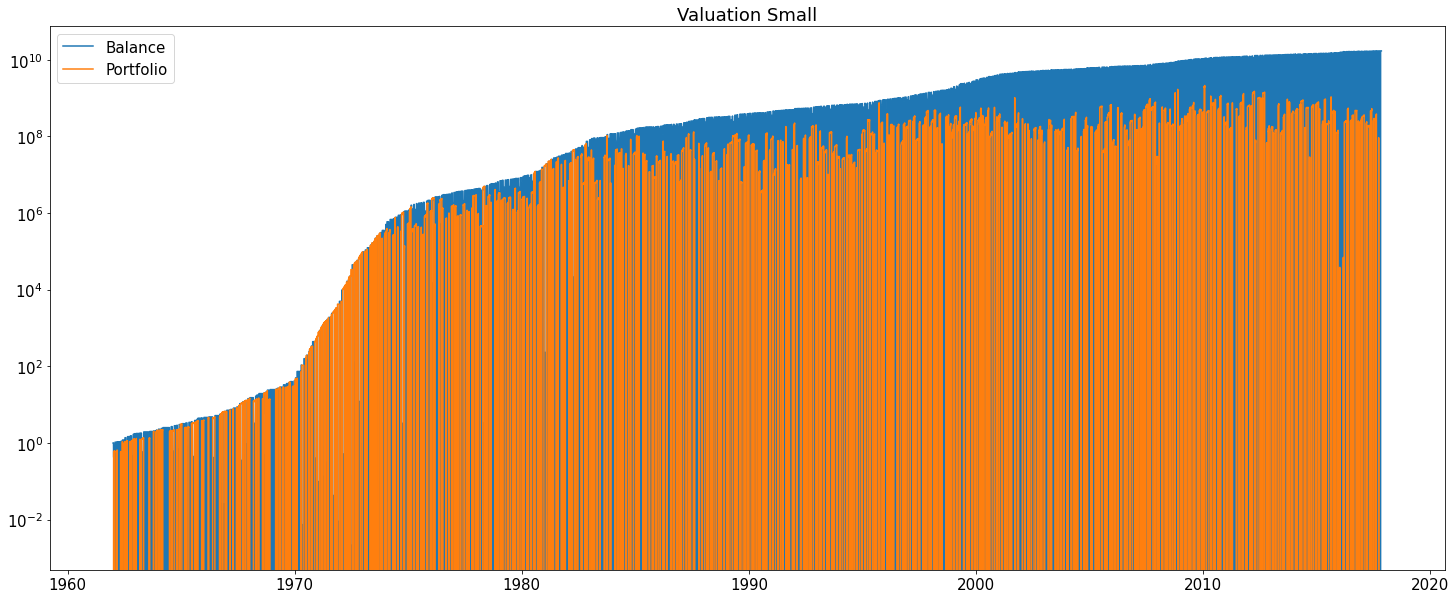

In [11]:
# now we are ready to create our plot!
dates_full = pd.date_range(start=start_date,end=end_date) # create the x axis

plt.figure(figsize=(25, 10))
plt.rcParams.update({'font.size': 15})
plt.plot(dates_full, Balance_dict.values())
plt.plot(dates_full, Portfolio_dict.values())
plt.yscale("log") # have to use log scale for the plot to be acceptable

# https://www.geeksforgeeks.org/matplotlib-pyplot-fill_between-in-python/
# fill area between x axis and blue line with the balance values
plt.fill_between(dates_full, Balance_dict.values()) 

plt.legend(("Balance","Portfolio"))
plt.title("Valuation Small")
plt.savefig("small.png")
plt.show()